<a href="https://colab.research.google.com/github/SKamara84/Climate_info/blob/main/precip25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from warnings import filterwarnings

filterwarnings('ignore')



In [2]:
from google.colab import data_table
data_table.enable_dataframe_formatter()


In [3]:
file_path = "/content/Precip81_24.csv"
df = pd.read_csv(file_path)
df.head(10)

,time_start,precipitation
0,"Jan 1, 1981",1.066
1,"Jan 6, 1981",0.763
2,"Jan 11, 1981",0.624
3,"Jan 16, 1981",0.315
4,"Jan 21, 1981",0.620
5,"Jan 26, 1981",0.989
6,"Feb 1, 1981",2.344
7,"Feb 6, 1981",3.200
8,"Feb 11, 1981",5.675
9,"Feb 16, 1981",2.233


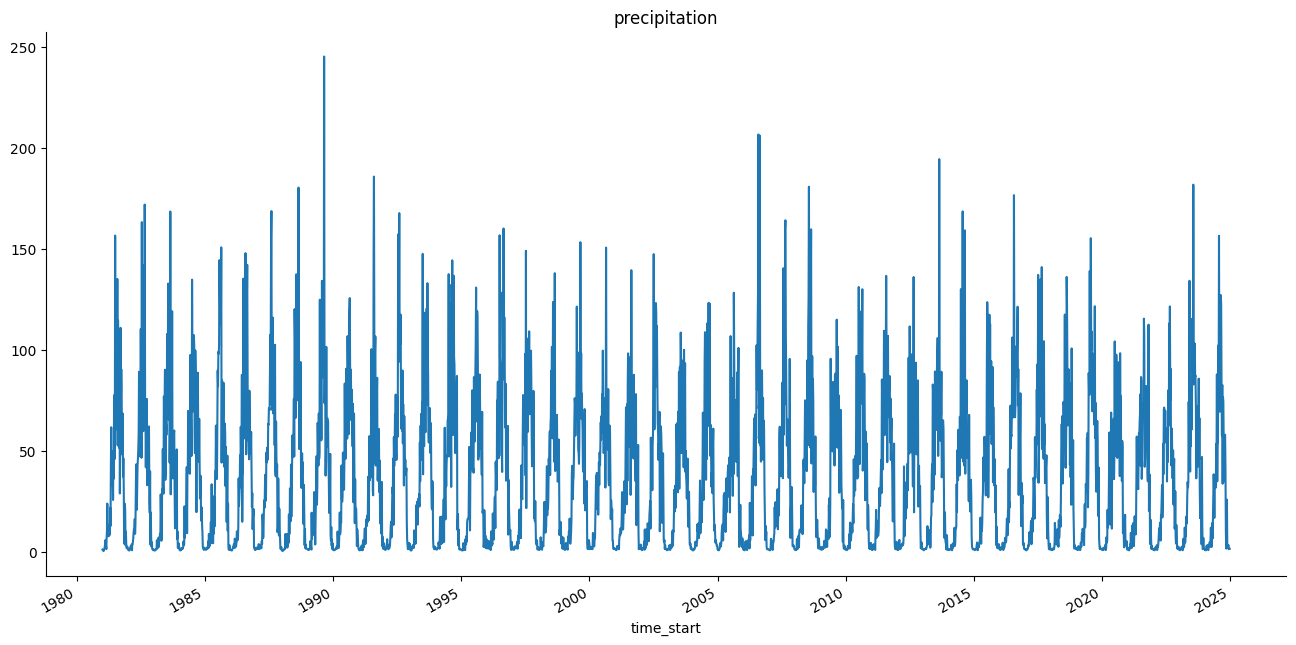

In [4]:
# @title precipitation1
df['time_start'] = pd.to_datetime(df['time_start'])
df.set_index('time_start', inplace=True)

from matplotlib import pyplot as plt
df['precipitation'].plot(kind='line', figsize=(16, 8), title='precipitation')
plt.gca().spines[['top', 'right']].set_visible(False)

# SECTION 1: Data Loading and Preprocessing for LSTM

In [6]:
def load_and_preprocess_data_lstm(file_path, date_column='time_start'):
    df = pd.read_csv(file_path)
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    monthly_df = df['precipitation'].resample('MS').mean().to_frame()
    monthly_df.dropna(inplace=True)
    return monthly_df


In [5]:
# ---------------------
# SECTION 1: Data Loading and Preprocessing for LSTM
# ---------------------

def load_and_preprocess_data_lstm(file_path):
    """
    Loads the data, converts the date column, sets it as index, resamples to monthly average.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pandas.DataFrame: Time series dataframe with monthly average precipitation.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Convert date
    df['time_start'] = pd.to_datetime(df['time_start'])

    # Set index
    df.set_index('time_start', inplace=True)

    # Resample data to monthly average
    monthly_df = df['precipitation'].resample('MS').mean().to_frame()
    monthly_df.dropna(inplace = True) # remove any nan generated due to no value at the start of the dataset
    return monthly_df


# Provide link to the file

In [ ]:
# Load and preprocess the data
file_path = "/content/Precip81_24.csv"
monthly_data = load_and_preprocess_data_lstm(file_path)
print(monthly_data.head())

            precipitation
time_start               
1981-01-01       0.729500
1981-02-01       2.892167
1981-03-01      11.541667
1981-04-01      12.307167
1981-05-01      41.982833


In [ ]:
def scale_data(data, scaler=None):
    """Scales time series data using Min-Max scaling.

    Args:
        data (pandas.DataFrame): Input time series data.
        scaler (sklearn.preprocessing.MinMaxScaler, optional): Scaler object. If None, a new scaler is created. Defaults to None.

    Returns:
        tuple: Scaled data and scaler object.
    """
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data = scaler.transform(data)
    return scaled_data, scaler


def create_sequences(scaled_data, seq_length, forecast_horizon):
    """
    Creates sequences from the scaled data for LSTM training, also creates multi-step target.

    Args:
        scaled_data (np.array): Scaled time series data.
        seq_length (int): Length of each input sequence.
        forecast_horizon (int): Number of steps in the future to predict.

    Returns:
        tuple: Input sequences (X) and corresponding target values (y).
    """
    X, y = [], []
    for i in range(len(scaled_data) - seq_length - forecast_horizon + 1):
         X.append(scaled_data[i:(i + seq_length), 0])
         y.append(scaled_data[i + seq_length: i + seq_length + forecast_horizon, 0])

    # Reshape data for LSTM
    X = np.array(X).reshape((np.array(X).shape[0], np.array(X).shape[1], 1))
    y = np.array(y)

    return X, y

def walk_forward_validation(data, sequence_length, forecast_horizon, train_size, epochs = 100, batch_size = 32):
        """
        Performs walk-forward validation and generates forecasts.

        Args:
             data (pandas.DataFrame): Time series data.
             sequence_length (int): Length of the input sequences.
             forecast_horizon (int): Number of steps to predict in the future.
             train_size (int): Number of months for initial train size and increment size.

        Returns:
             pandas.DataFrame: Dataframe with original and predicted values and the future forecast.
        """

        predictions_list = []
        rmse_list = []

        for t in range(train_size, len(data), train_size): # Walk forward through the dataset

                # Split the data
                train_data = data[:t]
                test_data = data[t:min(t + train_size, len(data))] #limit the size of test set

                # Scale the data, fit only on training data to avoid data leakage
                scaled_train, scaler_train = scale_data(train_data)
                scaled_test, _ = scale_data(test_data, scaler_train)

                # Create sequences
                X_train, y_train = create_sequences(scaled_train, sequence_length, forecast_horizon)
                X_test, y_test = create_sequences(scaled_test, sequence_length, forecast_horizon)

                # Build the model
                input_shape = (X_train.shape[1], 1)
                lstm_model = build_lstm_model(input_shape, forecast_horizon)

                # Train the model
                trained_lstm_model, _ = train_lstm_model(lstm_model, X_train, y_train, epochs = epochs, batch_size = batch_size)

                # Make predictions
                predictions = trained_lstm_model.predict(X_test)

                # Invert the scaling to bring it back to original scale
                predictions_original = np.array([scaler_train.inverse_transform(p.reshape(-1, 1)).flatten() for p in predictions])
                y_test_original = np.array([scaler_train.inverse_transform(p.reshape(-1,1)).flatten() for p in y_test])
                # ... (rest of the walk_forward_validation function)

                # Store predictions
                for i in range(len(predictions_original)):
                    # get time-period for the current record
                    start_date = test_data.index[i + sequence_length]
                    predicted_dates = pd.date_range(start=start_date, periods=forecast_horizon, freq="MS")

                    #create dataframe from prediction for storing them
                    predictions_df = pd.DataFrame({
                            'original': y_test_original[i],
                            'predicted': predictions_original[i]},
                         index = predicted_dates
                         )
                    predictions_list.append(predictions_df)

                # calculate RMSE for the current time window
                current_rmse = np.sqrt(mean_squared_error(y_test_original.flatten(),predictions_original.flatten()))
                rmse_list.append(current_rmse)


        #create a single dataframe from the list of dataframes
        predictions_df = pd.concat(predictions_list)

        # calculate overall rmse
        rmse = np.mean(rmse_list)
        print(f'Overall RMSE: {rmse}')
        return predictions_df


In [ ]:
def build_lstm_model(input_shape, forecast_horizon):
    """Builds an LSTM model for time series forecasting.

    Args:
        input_shape (tuple): Shape of the input data.
        forecast_horizon (int): Number of steps to predict in the future.

    Returns:
        tensorflow.keras.models.Sequential: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=forecast_horizon))  # Output layer with forecast_horizon units

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [ ]:
def train_lstm_model(model, X_train, y_train, epochs=100, batch_size=32):
    """Trains the LSTM model.

    Args:
        model (tensorflow.keras.models.Sequential): LSTM model to train.
        X_train (np.array): Training input data.
        y_train (np.array): Training target data.
        epochs (int, optional): Number of training epochs. Defaults to 100.
        batch_size (int, optional): Batch size for training. Defaults to 32.

    Returns:
        tuple: Trained LSTM model and training history.
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)  # Set verbose=0 to suppress training output
    return model, history

In [ ]:
sequence_length = 12  # Use the past 12 months to predict
forecast_horizon = 3  # Predict the next 3 months

In [ ]:
# Import necessary libraries
# ... (your import statements)

# Define load_and_preprocess_data_lstm function
# ... (your existing code)

# Define scale_data function
# ... (your existing code)

# Define create_sequences function
# ... (your existing code)

# Define build_lstm_model function (as shown above)

# Define train_lstm_model function (as shown above)

# Define walk_forward_validation function
# ... (your existing code)

# Define forecast_future_lstm function
# ... (your existing code)

# Set sequence_length and forecast_horizon
sequence_length = 12
forecast_horizon = 3

# Load and preprocess data
# ... (your existing code)

# Perform walk-forward validation
# ... (your existing code)

# Forecast future values
# ... (your existing code)

In [ ]:
# SECTION 5: Plotting Results and Forecast
# ---------------------
def plot_predictions(results, forecast, title = 'LSTM Model Evaluation and Forecast'):
    """
    Plots both the model's predictions and the future forecast.

    Args:
        results (pandas.DataFrame): DataFrame containing actual vs predicted
        forecast (pandas.DataFrame): DataFrame containing future forecast.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(results.index, results['original'], label='Actual', color = 'blue')
    plt.plot(results.index, results['predicted'], label='Predicted', color = 'red', linestyle = '--')
    plt.plot(forecast.index, forecast['predicted_precipitation'], label='Forecast', color = 'green')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Precipitation')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plotting results
plot_predictions(results, forecast_df)

NameError: name 'results' is not defined

In [ ]:
def walk_forward_validation(data, sequence_length, forecast_horizon, train_size, epochs = 100, batch_size = 32):
        """
        Performs walk-forward validation and generates forecasts.

        Args:
             data (pandas.DataFrame): Time series data.
             sequence_length (int): Length of the input sequences.
             forecast_horizon (int): Number of steps to predict in the future.
             train_size (int): Number of months for initial train size and increment size.

        Returns:
             pandas.DataFrame: Dataframe with original and predicted values and the future forecast.
        """

        all_predictions = []
        all_original = []
        all_dates = []  # Store all dates here
        rmse_list = []

        for t in range(train_size, len(data), train_size):
                # ... (rest of the code remains the same up to predictions_original)

                # Store predictions differently:
                all_original.extend(y_test_original.flatten())
                all_predictions.extend(predictions_original.flatten())

                # Store corresponding dates
                for i in range(len(predictions_original)):
                    start_date = test_data.index[i + sequence_length]
                    predicted_dates = pd.date_range(start=start_date, periods=forecast_horizon, freq="MS")
                    all_dates.extend(predicted_dates)

                # ... (rest of the loop remains the same)

        # Create a single DataFrame:
        predictions_df = pd.DataFrame({
            'original': all_original,
            'predicted': all_predictions
        }, index=all_dates)  # Use all_dates as the index

        # ... (rest of the function remains the same)

        return predictions_df